In [688]:
import numpy as np
import pandas as pd
import cvxpy as cp
import random

from pandas.io.pytables import performance_doc



class MyClassifier_25:  

    def __init__(self,dataset,class1:int,class2:int) -> None:
        self.w = None
        self.b = None
        self.classes = { 1 : class1, -1: class2, 0:None}
        self.dataset_train = dataset

        #data prep
        self.trainlabel,self.traindata = self.prepare_binary(self.dataset_train)
        self.yet_to_train_dataset = self.dataset_train
        self.sampled_dataset = None
        
        self.i = 0 # Dataset Iterator 
        self.sel_arr = np.zeros(self.traindata.shape[0]) # Binary Array indicating whether a sample -
                     # is selected or not in order of sample selection and not dataset index
        
        #Change these variables:
        self.perct_sel_smpls = 0.3 # percentage of Selected samples from dataset
        self.batch_size = 100 # Batch Size for samples
        self.mini_batch_size = 20 # Mini Batch Size for samples
        self.exploit_perc = 0.8 # Percentage of samples that are close to svm
        self.explore_perc = 1 - self.exploit_perc # Percentage of samples that are random
        # UNDERSTAND THAT EXPLORE AND EXPLOIT PERCENTAGES ARE PERCENTAGES FROM PERCENTAGE OF SELECTED SAMPLES
        # ie: if perct_sel_smpls = 0.3 and exploit_perc = 0.8,
        # then exploit_perc is essentially 0.8x0.3 = 0.24 of original dataset
        
        #train the classfier 
        self.selection_and_train()

        
    
    def prepare_binary(self,dataset):

        #USAGE    
        # Since we have to deal with a binary classifier to diffrentiate between digits 7 and 1, 
        # we choose only those examples.
        # If asked to train a classifier on any other pair a, b (say),
        # please pass the right arguments to the following function as follows:
        # trainlabel, traindata, dataTargetDf = prepare_binary(a,b)


        # We now assign +1 to one class and -1 to the other;
        # Therefore +1 and -1 will be the new labels
        class1 = self.classes[1]
        class2 = self.classes[-1]

        trainlabel = dataset.loc[(dataset['label']== class1)  | (dataset['label']== class2) ]['label']
        trainlabel.loc[trainlabel == class1] = 1
        trainlabel.loc[trainlabel == class2] = -1
        trainlabel = trainlabel.to_numpy()
    
        #In order to match dimensions of "traindata" and "trainlabel", we convert trainlabel to two dimension array
        # for hinge loss
        trainlabel= np.reshape(trainlabel, (trainlabel.shape[0],1))   

        # We now extract the features for the two classes
        traindata = dataset.loc[(dataset['label']== class1)  | (dataset['label']== class2) ]
        traindata = traindata.drop(labels = ["label"],axis = 1)
        traindata = traindata.to_numpy()

        # print(traindata.shape[1])



        return trainlabel, traindata

    def target_df(self,traindata,trainlabel):
        # Also creating a dataframe with these, so that we can randomize the order of the train data when needed without
        # losing the mapping between feature vectors and the target labels
        trainDf=pd.DataFrame(traindata)
        targetDf=pd.DataFrame(trainlabel,columns=['target'])
        
        dataTargetDf = pd.concat([trainDf, targetDf[['target']]], axis = 1)
        ##If randomizing the order, should we use the dataframe 'finalDf'?
        return dataTargetDf

    def subset(self,dataTargetDf, subsetfrac:float):
        
        # Usage: If 20% of the data is to be randomly selected
        # subsetDf = subset(dataTargetDf, 0.2)
        
        return dataTargetDf.sample(frac = subsetfrac)
    
    def sample_selection(self,training_sample):
        
        # This method accepts only 1 random training sample at a time and decides whether to send it or not
        
        mini_batch_slots_to_be_filled = int(self.perct_sel_smpls * self.mini_batch_size)
        batch_slots_to_be_filled = int(self.perct_sel_smpls * self.batch_size)
        mini_start = (self.i // self.mini_batch_size)*self.mini_batch_size
        mini_end = mini_start + (self.i % self.mini_batch_size) + 1
        print("mini_start: ",mini_start,"mini_end: ", mini_end)
        print("Mini Batch: ",self.sel_arr[mini_start:mini_end])
        
        # Explore
        # Random Binary value is assigned initially
        accept_sample = random.randint(0, 1)
        
        lbl, dt = self.prepare_binary(sample)
        # Exploit
        # after 50 percent completion, choose p1 and p3 over p2
        if ((self.i/self.dataset_train.shape[0])>=0.5 and (self.i/self.dataset_train.shape[0])<0.75 and \
            np.count_nonzero(self.sel_arr[mini_start:mini_end]) < mini_batch_slots_to_be_filled*self.exploit_perc):
            if(self.region(dt)=='p1' or self.region(dt)=='p3'):
                accept_sample = 1
        # after 75 percent completion, choose p2 over p1 and p3
        elif ((self.i/self.dataset_train.shape[0])>=0.75 and \
             np.count_nonzero(self.sel_arr[mini_start:mini_end]) < mini_batch_slots_to_be_filled*self.exploit_perc):
            if(self.region(dt)=='p3'):
                accept_sample = 1
        
        # No. of mini batch and batch slots that must be filled to satisfy percentage criteria
        print("If Mini Batch Count: ",np.count_nonzero(self.sel_arr[mini_start:mini_end])," >= mini slots ",mini_batch_slots_to_be_filled," then 0")
        if np.count_nonzero(self.sel_arr[mini_start:mini_end]) >= mini_batch_slots_to_be_filled:
            accept_sample = 0
            
        # Lower bound for mini batch percentage criteria
        print("If Mini Batch iterator: ",self.i % self.mini_batch_size," >= rem mini slots ",self.mini_batch_size - mini_batch_slots_to_be_filled, \
              "and Mini Batch Count: ",np.count_nonzero(self.sel_arr[mini_start:mini_end])," < mini slots ",mini_batch_slots_to_be_filled," then 1")
        if (self.i % self.mini_batch_size) >= (self.mini_batch_size - mini_batch_slots_to_be_filled) \
        and np.count_nonzero(self.sel_arr[mini_start:mini_end]) < mini_batch_slots_to_be_filled:
            accept_sample = 1
        
        start = (self.i // self.batch_size)*self.batch_size
        end = start + (self.i % self.batch_size) + 1
        print("start: ",start,"end: ", end)
        print("Batch: ",self.sel_arr[start:end])
        print("If Batch Count: ",np.count_nonzero(self.sel_arr[start:end])," >= slots ",batch_slots_to_be_filled, " then 0")
        if np.count_nonzero(self.sel_arr[start:end]) >= batch_slots_to_be_filled:
            accept_sample = 0
            
        # Lower bound for batch percentage criteria
        print("If Batch iterator: ",self.i % self.batch_size," >= rem slots ",self.batch_size - batch_slots_to_be_filled,\
             "and Batch Count: ",np.count_nonzero(self.sel_arr[start:end])," < slots ",batch_slots_to_be_filled, " then 1")
        if (self.i % self.batch_size) >= (self.batch_size - batch_slots_to_be_filled) \
        and np.count_nonzero(self.sel_arr[start:end]) < batch_slots_to_be_filled:
            accept_sample = 1
        
        if(self.i==0):
            accept_sample = random.randint(0, 1)
        
        print("accept_sample: ",accept_sample)
        print("~~~~~~~~~~~~~~~~~~~~~~~~")
        # Returns True if sample is accepted and False otherwise
        return True if accept_sample == 1 else False
    
    def selection_and_train(self):
        
        self.i = 0 # Dataset Iterator 
        
        # Iterate over dataset until it is exhausted
        while(self.i<self.sel_arr.size-1):
        
            # Sample and remove the sample from the dataset (to avoid duplicates in future sampling)
            sample = self.yet_to_train_dataset.sample(n=1)
            self.yet_to_train_dataset.drop(sample.index)
            
            # Perform next steps if sample selection is true
            if self.sample_selection(sample) is True:
                
                if self.sampled_dataset is None:
                    self.sampled_dataset = sample
                else:
                    self.sampled_dataset = self.sampled_dataset.append(sample, ignore_index=True)
               
                self.sel_arr[self.i] = 1
                
                if (self.i % self.batch_size) == 0 and (self.i != 0):
                    lbl, dt = self.prepare_binary(self.sampled_dataset)
                    self.train(dt,lbl)
                
            self.i+=1
        
        lbl, dt = self.prepare_binary(self.sampled_dataset)
        self.train(dt,lbl)   
    
    def _hinge_loss_svm(self,traindata, trainlabel,W,w):
        m =traindata.shape[1]
        # Equation for the regularizer.
        # It is the lambda*(norm2 of W)**2
        # Here "lambda" is a non negative constant
        lambd = cp.Parameter(nonneg=True)

        ## Ideally we will have to try using different values fro "lambda"
        ## For the sake of testing the code, we have set it to 0.01
        ## Do we need to have a lambda?
        lambd = 0.01 
        reg_loss = cp.norm(W,p=2)**2
        
        #hinge loss
        hinge_loss = cp.sum(cp.pos(1-cp.multiply(trainlabel,traindata @ W - w)))
        

        
        #Objective is to minimize reg_loss and hinge_loss
        # objective_func = cp.Minimize(hinge_loss/m + lambd*reg_loss)
        prob = cp.Problem(cp.Minimize(hinge_loss/m + lambd*reg_loss))
        # Now framing the LP, along with the constraints
        return prob

    def _normal_loss_svm(self,traindata,trainlabel, W,w):
        #Constraint
        # For every feature vector traindata[i] and its corresponding label trainlabel[i]:
        # W^T*traindata[i] + w >= 1
        const = [trainlabel[i]*(traindata[i]@ W + w) >= 1 for i in range(traindata.shape[0])]
        ##Check the dimensions in the above constraint equation
        
        #Objective is to minimize reg_loss and hinge_loss
        # objective_func = cp.Minimize(hinge_loss/m + lambd*reg_loss)
        objective_func = cp.Minimize(0.5*cp.norm(W,p=2)**2)
        prob = cp.Problem(objective_func,constraints=const)
        # Now framing the LP, along with the constraints
        return prob

    def train(self,traindata,trainlabel):
        
        #USAGE
        # W, w = train(traindata, trainlabel)

        # m: Number of feature vectors
        # W and w: Weight vector and Bias value respectively
        print(traindata.shape)
        m = traindata.shape[1]
        W = cp.Variable((m,1))
        w = cp.Variable()

        
        prob = self._hinge_loss_svm(traindata,trainlabel,W,w)

        prob.solve()
        
        # Solving the problem would give us the optimal values from W and w;
        # which have to be returned, so that we can use them while testing

        ## adding to class variable
        self.w = W
        self.b = w
        

    def f(self,test_input):
        test_val = test_input.dot(self.w.value) -  self.b.value
        if test_val < -1:
            test_val= -1
        elif test_val > 1:
            test_val = 1
        else:
            test_val = 0
        estimated_class = self.classes.get(test_val)
        return estimated_class
    
    def region(self,test_input):
        if self.dist(test_input)<-1:
            return "p1"
        elif dist(test_input)>1:
            return "p3"
        else:
            return "p2"
        
    def dist(self,test_input):
        return (test_input.dot(self.w.value) -  self.b.value)
    
    def assess_classifier_performance(self,performance):
        performance = np.asarray(performance)
        correct = (np.count_nonzero(performance)/len(performance))*100
        return correct

    def test(self,dataset_test):
        testlabel,testdata= self.prepare_binary(dataset_test)
        res = []
        performance = 0
        for i in range(testdata.shape[0]):
            result = self.f(testdata[i])
            res.append(result)
            
            actual_class = self.classes.get(int(testlabel[i]))
            ## assessing performance
            if result == actual_class:
                performance += 1
         
        performance /= testlabel.shape[0]
        return res, performance
    
    def plot_classifier_performance_vs_number_of_samples(self):
        pass

    
        


        


In [689]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

mnist_train = pd.read_csv("train.csv")
#Take copies of the master dataframes

train = mnist_train.copy()

train_7 = train.loc[train['label'] == 7]
train_1 = train.loc[train['label'] == 1]
train = train.loc[train['label'].isin([1,7])]
train_rdm = train.sample(frac = 0.5)
test_rdm = train.sample(frac = 0.2)

In [690]:
my_clf = MyClassifier_25(train,1,7)

mini_start:  0 mini_end:  1
Mini Batch:  [0.]


AttributeError: 'NoneType' object has no attribute 'value'

In [674]:
res, performance = my_clf.test(train_rdm)

In [675]:
performance

0.9742404227212682

In [561]:
a = np.array([1,2,3])
a[0:2]

array([1, 2])

In [532]:
my_clf.i = 0
#chck = np.zeros((1000), dtype=bool)
my_clf.sel_arr.fill(0)
while(my_clf.i<my_clf.sel_arr.size-1):
    if my_clf.sample_selection(1) == True:
        my_clf.sel_arr[my_clf.i] = 1
    my_clf.i += 1
#np.count_nonzero(chck)/1000
my_clf.sel_arr

mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 0
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  0  vs rem mini slots  -1
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  0  vs rem slots  -6
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 0
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  0
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  -5
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 0
Batch:  [1. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  1
Batch:  [1. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  -4
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 0
Batch:  [1.

Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  80
Batch:  [1. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  75
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 80
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  81
Batch:  [1. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  76
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 80
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  82
Batch:  [1. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  77
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 80
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini slots  83

Batch iterator:  4  vs rem mini slots  163
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  4  vs rem slots  158
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 165
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  0  vs rem mini slots  164
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  5  vs rem slots  159
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 165
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  165
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  6  vs rem slots  160
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 165
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  166
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slo

Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  260
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  255
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 260
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  261
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  256
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 260
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  262
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  257
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 260
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini 

Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  360
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  355
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 360
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  361
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  356
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 360
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  362
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  357
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 360
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini 

Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  460
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  455
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 460
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  461
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  456
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 460
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  462
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  457
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 460
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini 

Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  560
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  555
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 560
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  561
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  556
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 560
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  562
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  557
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 560
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini 

self.i//self.mini_batch_size*self.mini_batch_size 660
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  660
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  655
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 660
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  661
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  656
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 660
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  662
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  657
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 660
Batch:  [1. 0. 0. ... 0. 0. 

self.i//self.mini_batch_size*self.mini_batch_size 760
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  760
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  755
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 760
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  761
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  756
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 760
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  762
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  757
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 760
Batch:  [1. 0. 0. ... 0. 0. 

Batch iterator:  2  vs rem mini slots  851
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  12  vs rem slots  846
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 850
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  852
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  13  vs rem slots  847
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 850
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini slots  853
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  14  vs rem slots  848
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 855
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  0  vs rem mini slots  854
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs 

self.i//self.mini_batch_size*self.mini_batch_size 940
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  940
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  935
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 940
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  941
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  936
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 940
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  942
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  937
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 940
Batch:  [0. 1. 0. ... 0. 0. 

batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1040
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  1040
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  1035
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1040
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  1041
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  1036
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1040
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  1042
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  1037
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1040
Batc

batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1140
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  1140
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  1135
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1140
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  1141
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  1136
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1140
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  1142
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  1137
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1140
Batc

Batch iterator:  4  vs rem mini slots  1233
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  14  vs rem slots  1228
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1235
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  0  vs rem mini slots  1234
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  15  vs rem slots  1229
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1235
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  1235
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  16  vs rem slots  1230
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1235
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  1236
Batch:  [0. 0. 0. ... 0. 0

Batch iterator:  1  vs rem slots  1315
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1320
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  1321
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  1316
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1320
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  1322
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  1317
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1320
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini slots  1323
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  4  vs rem slots  1318
accept_sample:  0
~~~~~~~~~~~~~~~~

Batch iterator:  18  vs rem slots  1412
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1415
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini slots  1418
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  19  vs rem slots  1413
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1420
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  0  vs rem mini slots  1419
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  0  vs rem slots  1414
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1420
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  1420
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  1415
accept_sample:  0
~~~~~~~~~~~~~~

Batch iterator:  10  vs rem slots  1504
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1510
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  1510
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  11  vs rem slots  1505
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1510
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  1511
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  12  vs rem slots  1506
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1510
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  1512
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  13  vs rem slots  1507
accept_sample:  0
~~~~~~~~~~~~

mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1600
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  1600
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  1595
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1600
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  1601
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  1596
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1600
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  1602
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  1597
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_b

mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1700
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  1700
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  1695
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1700
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  1701
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  1696
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1700
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  1702
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  1697
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_b

~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1800
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  1800
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  1795
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1800
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  1801
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  1796
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1800
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  1802
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  1797
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mi

~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1900
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  1900
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  1895
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1900
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  1901
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  1896
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 1900
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  1902
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  1897
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mi

accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2000
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2000
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  1995
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2000
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2001
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  1996
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2000
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2002
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  1997
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots

accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2100
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2100
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  2095
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2100
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2101
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  2096
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2100
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2102
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  2097
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots

Batch iterator:  0  vs rem slots  2194
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2200
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2200
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  2195
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2200
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2201
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  2196
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2200
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2202
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  2197
accept_sample:  0
~~~~~~~~~~~~~~~~

accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2280
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2280
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  2275
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2280
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2281
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  2276
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2280
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2282
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  2277
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots

Batch iterator:  0  vs rem slots  2374
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2380
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2380
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  2375
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2380
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2381
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  2376
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2380
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2382
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  2377
accept_sample:  0
~~~~~~~~~~~~~~~~

Batch iterator:  0  vs rem mini slots  2474
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  15  vs rem slots  2469
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2475
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2475
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  16  vs rem slots  2470
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2475
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2476
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  17  vs rem slots  2471
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2475
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2477
Batch:  [0. 0. 0. ... 0. 0

Batch iterator:  0  vs rem slots  2554
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2560
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2560
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  2555
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2560
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2561
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  2556
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2560
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2562
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  2557
accept_sample:  0
~~~~~~~~~~~~~~~~

Batch iterator:  0  vs rem slots  2654
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2660
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2660
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  2655
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2660
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2661
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  2656
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2660
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2662
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  2657
accept_sample:  0
~~~~~~~~~~~~~~~~

Batch iterator:  0  vs rem slots  2754
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2760
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2760
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  2755
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2760
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2761
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  2756
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2760
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2762
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  2757
accept_sample:  1
~~~~~~~~~~~~~~~~

Batch iterator:  0  vs rem slots  2854
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2860
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2860
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  2855
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2860
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2861
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  2856
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2860
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2862
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  2857
accept_sample:  1
~~~~~~~~~~~~~~~~

Batch iterator:  0  vs rem slots  2954
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2960
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  2960
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  2955
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2960
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  2961
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  2956
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 2960
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  2962
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  2957
accept_sample:  0
~~~~~~~~~~~~~~~~

Batch iterator:  0  vs rem slots  3054
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3060
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  3060
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  3055
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3060
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  3061
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  3056
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3060
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  3062
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  3057
accept_sample:  0
~~~~~~~~~~~~~~~~

Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  0  vs rem slots  3154
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3160
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  3160
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  3155
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3160
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  3161
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  3156
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3160
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  3162
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem s

Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  0  vs rem slots  3254
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3260
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  3260
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  3255
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3260
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  3261
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  3256
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3260
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  3262
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem s

Batch:  [1. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  0  vs rem slots  3354
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3360
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  3360
Batch:  [1. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  3355
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3360
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  3361
Batch:  [1. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  3356
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3360
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  3362
Batch:  [1. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem s

Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  0  vs rem slots  3454
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3460
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  3460
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  3455
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3460
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  3461
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  3456
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3460
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  3462
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem s

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini slots  3548
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  9  vs rem slots  3543
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3550
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  3585
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  6  vs rem slots  3580
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3585
Batch:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3620
Batch:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Batch iterator:  2  vs rem mini slots  3661
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  3656
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3660
Batch:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.

Batch iterator:  1  vs rem mini slots  3700
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  3695
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3700
Batch:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  3740
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  3735
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3740
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  3780
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  3775
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3780
Batch:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0

 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini slots  3823
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  4  vs rem slots  3818
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3825
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  3867
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  8  vs rem slots  3862
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3865
Batch:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0.]  vs mini slots  1
Batch iterator:  4  vs rem mini slots  3918
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  19  vs rem slots  3913
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3920
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  3962
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  3957
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 3960
Batch:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  0  vs rem mini slots  4009
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  10  vs rem slots  4004
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4010
Batch:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

 0. 0.]  vs mini slots  1
Batch iterator:  3  vs rem mini slots  4062
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  4057
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4060
Batch:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  4116
Batch:  [1. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  17  vs rem slots  4111
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4115
Batch:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  0  vs rem mini slots  4159
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  0  vs rem slots  4154
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4160
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  0  vs rem mini slots  4219
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  0  vs rem slots  4214
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4220
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  3  vs rem slots  4277
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4280
Batch:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  16  vs rem slots  4350
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4355
Batch:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  4356
Batch:  [0. 0. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  17  vs rem slots  4351
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots

Batch iterator:  4  vs rem mini slots  4433
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  14  vs rem slots  4428
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4435
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  0  vs rem mini slots  4434
Batch:  [0. 0. 1. ... 0. 0. 0.]  vs slots  6
Batch iterator:  15  vs rem slots  4429
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4435
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Batch iterator:  0  vs rem mini slots  4519
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  0  vs rem slots  4514
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4520
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  1  vs rem mini slots  4520
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  1  vs rem slots  4515
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4520
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  vs mini slots  1
Batch iterator:  2  vs rem mini slots  4521
Batch:  [0. 1. 0. ... 0. 0. 0.]  vs slots  6
Batch iterator:  2  vs rem slots  4516
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini batch slots 1
batch slots 6
self.i//self.mini_batch_size*self.mini_batch_size 4520
Batch:  [0. 0. 0. 0. 0. 0. 0. 0. 0.

array([1., 1., 1., ..., 0., 1., 0.])

In [479]:
np.zeros((10), dtype=bool)

array([False, False, False, False, False, False, False, False, False,
       False])

In [286]:
#We will use TSNE to reduce the datset down to 2 Dimensions and then plot it using Matplotlib
from sklearn.manifold import TSNE
import time
tsne = TSNE(n_components = 2, random_state = 42)
t0 = time.time()
train_reduced = tsne.fit_transform(train_rdm)
t1 = time.time()

t1-t0

36.25676107406616

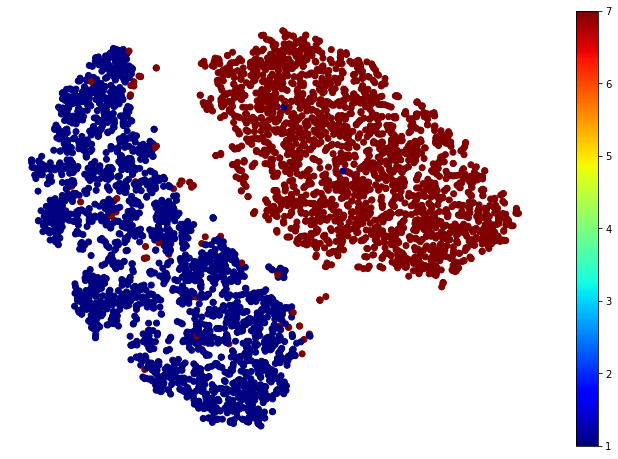

In [287]:
plt.figure(figsize=(12, 8))
plt.scatter(train_reduced[:,0], train_reduced[:,1], c = train_rdm['label'], cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

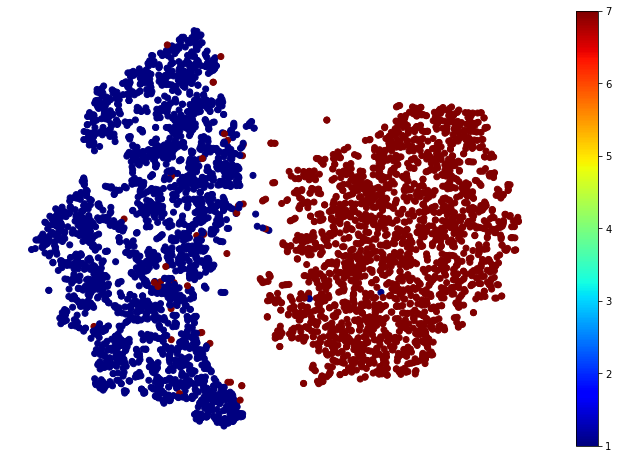

In [256]:
plt.figure(figsize=(12, 8))
plt.scatter(train_estimate_reduced[:,0], train_estimate_reduced[:,1], c = train_rdm['label'], cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

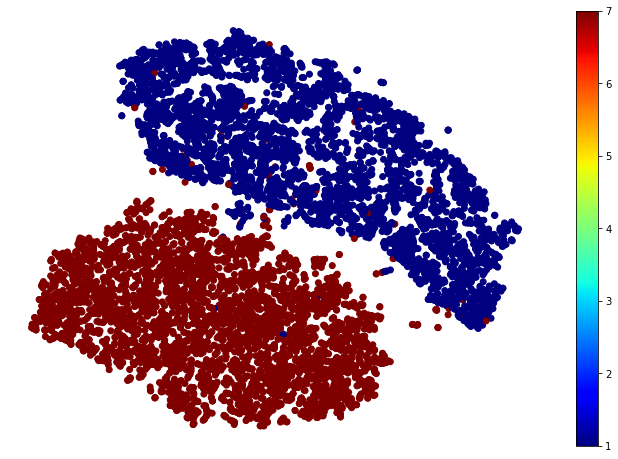

In [35]:
plt.figure(figsize=(12, 8))
plt.scatter(train_1_reduced[:,0], train_1_reduced[:,1], c = train['label'], cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

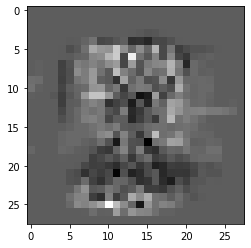

In [288]:
weight_show = plt.imshow(my_clf.w.value.reshape(28,28), cmap=mpl.cm.binary)

In [110]:
from sklearn.svm import SVC
clf = SVC(C = 1e5, kernel = 'linear')
X, y = train.drop(labels = ["label"],axis = 1).to_numpy(), train["label"]
clf.fit(X,y)

SVC(C=100000.0, kernel='linear')

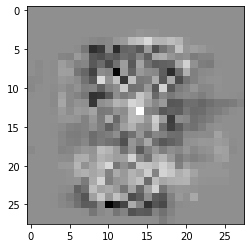

In [112]:
eight_show = plt.imshow(clf.coef_.reshape(28,28), cmap=mpl.cm.binary)

In [119]:
clf.coef_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [120]:
my_clf.w.value

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.0

In [118]:
diff

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.08976819e-13,  7.33870688e-13,  1.10122380e-13,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

AttributeError: 'AxesImage' object has no property 'color_continuous_scale'

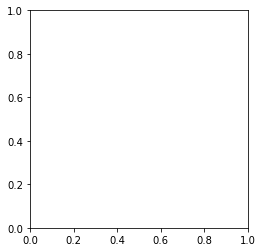

In [125]:
diff = np.subtract(clf.coef_,my_clf.w.value.reshape(1,-1))
eight_show = plt.imshow(diff.reshape(28,28), color_continuous_scale='gray')
# eight_show.update_xaxes(side="top")